In [1]:
import tensorflow as tf
import sys
sys.path.append("../")
from federated.utils.mitbih_data_preprocessing import load_data
from sklearn.metrics import confusion_matrix
import numpy as np
from matplotlib import pyplot as plt
import itertools

In [2]:
import nest_asyncio
nest_asyncio.apply()

## Loading model and test dataset

In [3]:
model = tf.keras.models.load_model("../history/logdir/test_v2")
X_test, y_test = load_data(data_analysis=True)

X_test = X_test.reshape(len(X_test), X_test.shape[1],1)
X_test.shape

(21892, 186, 1)

## Evaluating Model

In [4]:
scores = model.evaluate(X_test, y_test, verbose=0)
print(f"Accuracy: {scores[1]*100}%, Loss: {scores[0]}")

Accuracy: 65.59473872184753%, Loss: 1.8306316137313843


In [5]:
y_pred = model.predict(X_test)

In [6]:
y_test = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

## Confusion Matrix

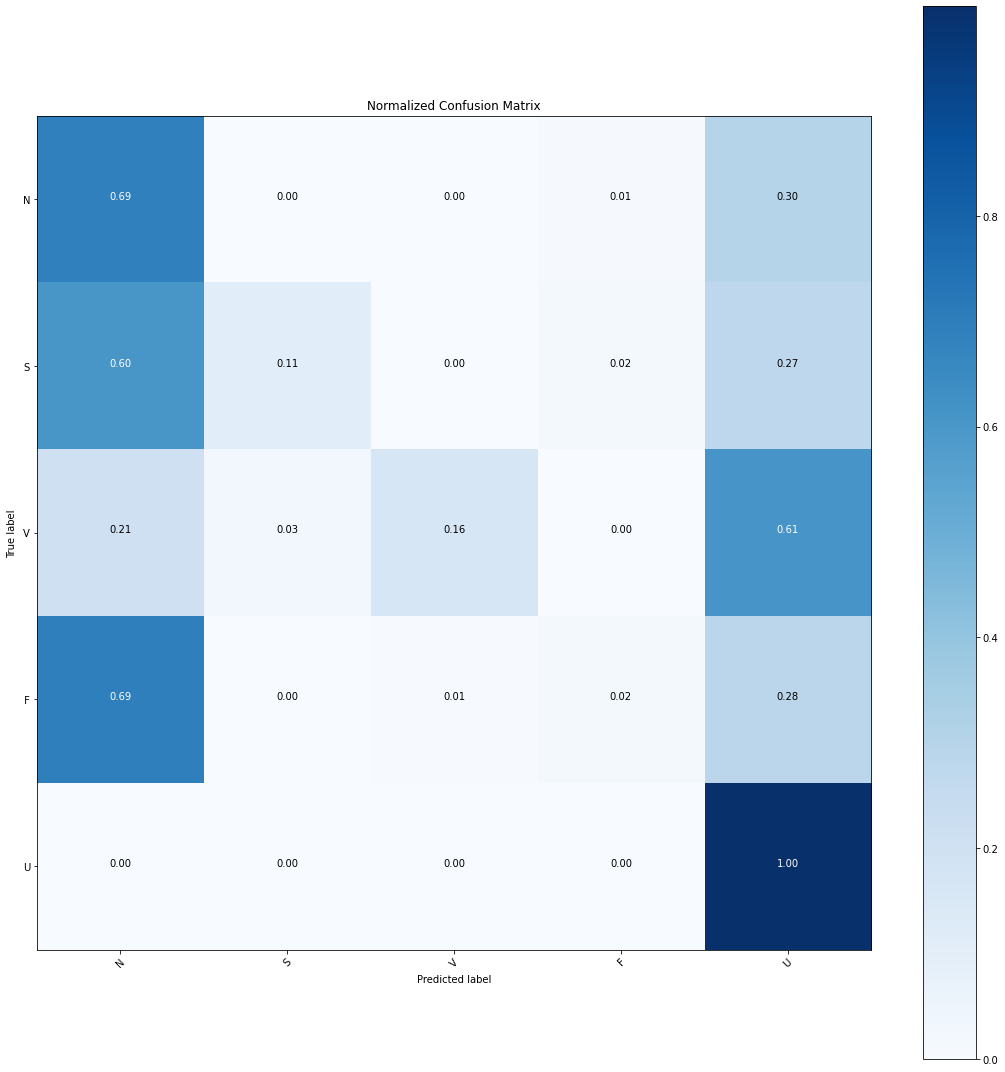

In [22]:
cnf_matrix = confusion_matrix(y_test, y_pred)

labels = ["N", "S", "V", " F", "U"]

plt.figure(figsize=(15,15))
cnf_matrix =  cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Normalized Confusion Matrix")
plt.colorbar()
ticks = np.arange(len(labels))
plt.xticks(ticks, labels, rotation=45)
plt.yticks(ticks, labels)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j,i,format(cnf_matrix[i,j], '.2f'), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > cnf_matrix.max()/2 else "black")

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Predicted label")


plt.show()


    